In [7]:
%matplotlib inline
import numpy as np
import random
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [8]:
pos=[(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(1,1),(-1,1),(1,-1)]
class World(object):
  def __init__(self,KingBool,StochWindBool):
    self.width=10
    self.height=7
    self.start=(3,0) #row,col
    self.current=self.start
    self.goal=(3,7)
    self.wind=[0,0,0,1,1,1,2,2,1,0]
    self.stochwind=StochWindBool
    self.king=KingBool
    self.ndir=4
    if self.king:
      self.ndir=8
  def move(self,action):
    new_pos=np.add(list(self.current),list(action))
    new_pos[0]=new_pos[0]-self.wind[self.current[1]]
    if self.stochwind:
      wind = random.choice([1, 0, -1])
      if self.wind[self.current[1]]!=0:
        new_pos[0]=new_pos[0]+wind
    new_pos[0]=max(0,min(new_pos[0],self.height-1))
    new_pos[1]=max(0,min(new_pos[1],self.width-1))
    goal=list(self.goal)
    if (new_pos[0]==goal[0]) and (new_pos[1]==goal[1]):
      reward=1
    else:
      reward=-1
    return [(new_pos[0],new_pos[1]),reward]

  def check(self,pos,action):
    new_pos=np.add(list(pos),list(action))
    if (new_pos[0]<0) or (new_pos[0]>=self.height) or (new_pos[1]<0) or (new_pos[1]>=self.width):
      return False
    return True

  def generate_possible_action(self,position):
    action=[]
    for i in range(self.ndir):
      if self.check(position,pos[i]):
        action.append(pos[i])
    return action

In [9]:
class Agent(object):
  def __init__(self,a,e,world:World):
    self.alpha=a
    self.epsilon=e
    self.gamma=0.9
    self.world=world
    self.Q_val=self.make_table()
    self.step_num=0

  def make_table(self):
    Table={}
    for x in range(self.world.height):
      for y in range(self.world.width):
        pos=(x,y)
        Table[pos]={}
        actions=self.world.generate_possible_action(pos)
        for action in actions:
          Table[pos][action]=0
    return Table

  def get_best(self,pos):
    maxVal=np.NINF
    bestAction= None
    for (action, value) in self.Q_val[pos].items():
      if value>maxVal:
        maxVal=value
        bestAction=action
    return bestAction
  
  def choose_action(self,pos):
    legal_action=list(self.Q_val[pos].keys())
    nextState=self.world.start
    action=None

    randNum = np.random.rand()

    if randNum<self.epsilon:
      explore = random.randint(0,len(legal_action)-1)
      action = legal_action[explore]
    else:
      action = self.get_best(pos)
    
    nextState=np.add(pos,action)
    temp = nextState[0]-self.world.wind[pos[1]]
    if temp<0:
      temp=0
    nextState[0]=temp
    return action

  def Sarsa(self):
    self.world.current=self.world.start
    visited=[]
    action_taken=[]
    visited.append(self.world.start)
    chosen_action=self.choose_action(self.world.current)
    newPosReward=None
    converged=True
    nstep=0
    while True:
      #take A observe R and S'
      newPosReward=self.world.move(chosen_action)
      newPos=newPosReward[0]
      reward=newPosReward[1]
      visited.append(newPos)
      action_taken.append(chosen_action)
      self.step_num+=1
      nstep+=1
      #choose A' from S' with greedy
      nextAction = self.choose_action(newPos)

      #update Q
      oldQ=self.Q_val[self.world.current][chosen_action]
      self.Q_val[self.world.current][chosen_action]+=self.alpha*(reward+self.gamma*self.Q_val[newPos][nextAction]-self.Q_val[self.world.current][chosen_action])

      if abs(oldQ-self.Q_val[self.world.current][chosen_action])>0.0001:
        converged=False
      self.world.current = newPos
      chosen_action = nextAction

      if (self.world.current == self.world.goal):
        break

    return converged, visited, action_taken

  def play(self):
    self.world.current=self.world.start
    visited=[]
    action_taken=[]
    visited.append(self.world.start)
    chosen_action=self.get_best(self.world.current)
    while True:
       newPosReward=self.world.move(chosen_action)
       newPos=newPosReward[0]
       visited.append(newPos)
       action_taken.append(chosen_action)

       nextAction = self.get_best(newPos)

       self.world.current = newPos
       chosen_action = nextAction
       
       if (self.world.current == self.world.goal):
         break
    return visited, action_taken

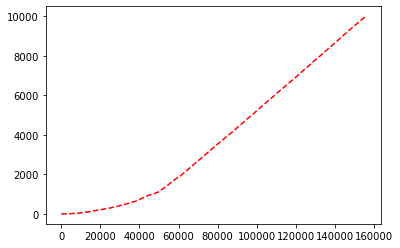

15.572657265726573


In [10]:
testWorld = World(KingBool=True, StochWindBool=True)
testAgent = Agent(0.1, 0.001, testWorld)
timestep=[0]
episode = [0]
convergedX=[]
convergedY=[]

alreadyConverged = False
for x in range(10000):
  testAgent.epsilon=1/(10*(x+1))
  result=testAgent.Sarsa()
  timestep.append(testAgent.step_num)
  episode.append(x)
  if (result[0] and not alreadyConverged):
    print('found optimal')
    print(result[1])
    final_path = result[1]
    print('list of action')
    print(result[2])
    route=result[1]
    convergedX.append(x)
    convergedY.append(testAgent.step_num)
    alreadyConverged = True

from matplotlib import pyplot as plt
plt.plot(timestep,episode,'r--',convergedY,convergedX,'bs')
plt.show()
print(timestep[-1]/episode[-1])
#print(convergedX)
#print(convergedY)


8
[(3, 0), (4, 1), (5, 2), (5, 3), (4, 4), (4, 5), (5, 6), (3, 7)]
[(1, 1), (1, 1), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1)]


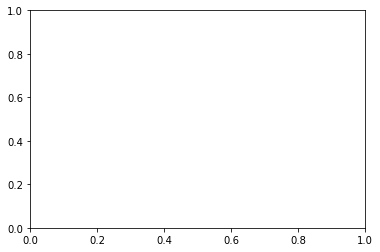

In [11]:
route = testAgent.play()
print(len(route[0]))
print(route[0])
print(route[1])
L = 7				
C = 10			
fig, ax = plt.subplots()	# Create figure
a = np.zeros((L,C))		# Create zero array of dimensions L,C
a[3][7]=1
a[3][0]=1
def animate(c):
  if c>0:
    a[route[0][c-1][0],route[0][c-1][1]]=0
  a[route[0][c][0],route[0][c][1]]=1

  ax.imshow(a, cmap=plt.cm.gray, interpolation='nearest')
  
anim = FuncAnimation(fig, animate,frames=len(route[0]), interval=2000/len(route))
plt.show()
                               
#HTML(anim.to_html5_video())

In [12]:
def draw_path(path):
    
    x = [point[1]+0.5 for point in path]
    y = [-point[0]-0.5 for point in path]
    
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.scatter([0.5, 7.5], [-3.5, -3.5]) #start and goal
    
    ax.set_xlim(0, 10)
    ax.set_ylim(-7, 0)
    
    ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], minor=False)
    ax.set_xticklabels(['0', '0', '0', '1', '1', '1', '2', '2', '1', '0'], minor=False)
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], minor=True)
    ax.set_yticks([0, -1, -2, -3, -4, -5, -6, -7], minor=False)
    ax.tick_params(axis='y', colors='white')
    
    ax.xaxis.grid(True, which='minor')
    ax.yaxis.grid(True, which='major')

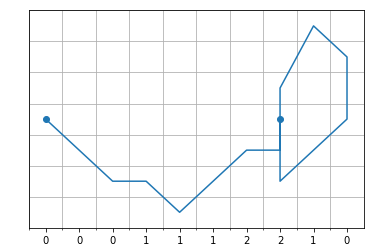

In [20]:
route = testAgent.play()
draw_path(route[0])

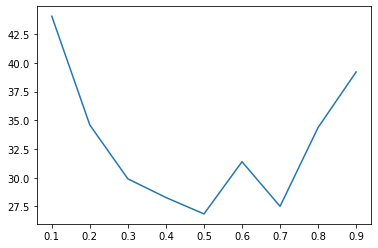

In [10]:
alphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #picking choosing the best alpha for fixed epsilon
results = []
for alpha in alphas:
  testWorld = World(KingBool=True, StochWindBool=True)
  testAgent = Agent(alpha, 0.01, testWorld)
  timestep=[0]
  episode = [0]
  convergedX=[]
  convergedY=[]

  #alreadyConverged = False
  for x in range(1000):
    result=testAgent.Sarsa()
    timestep.append(testAgent.step_num)
    episode.append(x)
  results.append(timestep[-1]/episode[-1])
plt.plot(alphas,results)
plt.show()

In [11]:
alphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
epsilons = [0.1,0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002,0.0001]
bestVal = np.Inf
bestPair = None 
for alpha in alphas:
  for epsilon in epsilons:
    testWorld = World(KingBool=False, StochWindBool=False)
    testAgent = Agent(alpha, epsilon, testWorld)
    timestep=[0]
    episode = [0]
    for x in range(500):
      result=testAgent.Sarsa()
      timestep.append(testAgent.step_num)
      episode.append(x)
    if timestep[-1]/episode[-1]<bestVal:
      bestVal=timestep[-1]/episode[-1]
      bestPair=(alpha,epsilon)
print(bestPair,' ',bestVal)

(0.9, 0.0001)   18.935871743486974
